# Comparisons and analysis

This notebook is for getting the simulated data done on the cluster and then doing funky comparisons and analysis

In [1]:
# First Import the packages.
from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib.colors import ListedColormap
from turbo_colormap import *
from scipy import stats
#matplotlib.style.use('ggplot')
import inspect
import os
import csv 
import time

import glob
import pandas as pd

# Now Import our data from our data folder:

# Get all csv filenames in a folder
all_files = glob.glob("do-not-track/*.csv")
#all_files

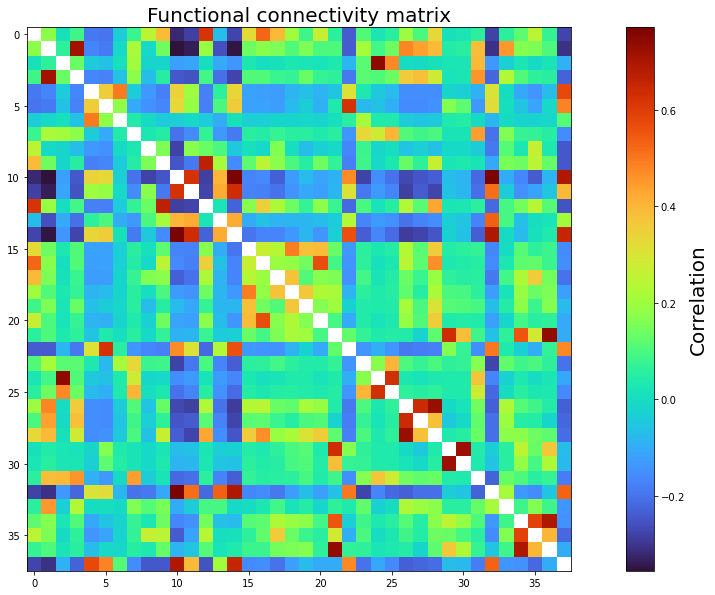

In [2]:
# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")

# Comparing FC_experimental Vs FC_Simulation with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

cs=plt.imshow(FCM_exp, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

# Building Heterogeneous Array for w_ei

In [141]:
# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

# Monitors or not?  (Aka BOLD or not?)
ParamsDict["BOLD"] = True

# Change to Binary Connectome? (If True, will change the connectome into binary)
ParamsDict["BINARY"] = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
ParamsDict["Snip"] = 10
# Note, if BOLD = False, Snip gets multiplied by 1000, later in the SimulationPipeline code.  Not the actual dictionary element though.  

# Set the Random State/Seed for the Stochastic Integrator:
ParamsDict["RandState"] = 118

# Set Simulation Length:
ParamsDict["Simul_length"] = 1.2e6

# Set Linear Coupling Constant:
ParamsDict["G"] = np.array([0.47]) 

# Set integrator time step dt.
ParamsDict["dt"] = 0.1

# Set Additive Noise strength
ParamsDict["noise"] = np.array([0.000013])

# Set Wilson Cowan Model Parameters
ParamsDict["MODEL_c_ee"] = np.array([12.0])
ParamsDict["MODEL_c_ei"] = np.array([15.0])
ParamsDict["MODEL_c_ie"] = np.array([10.0])
ParamsDict["MODEL_c_ii"] = np.array([8.0])

# Define Model
ParamsDict["MODEL"] = models.WilsonCowan(c_ee=ParamsDict["MODEL_c_ee"],c_ei=ParamsDict["MODEL_c_ei"],c_ie=ParamsDict["MODEL_c_ie"] ,c_ii=ParamsDict["MODEL_c_ii"]) 

In [97]:
df = pd.read_csv("CortexDensities.csv",delimiter=",")
w_ei = (df.excitatory/df.inhibitory)
# Sort w_ei
w_ei= pd.DataFrame(w_ei)
#w_ei.sort_values(by=df.columns[1])

w_ei.columns = ["Ratio"]
df1 = w_ei.sort_values(by="Ratio")

# Add Gradient.  + Profit. 
df1["Gradient"] = 12 + np.linspace(0,6,38)
Grad = df1.sort_index()["Gradient"].values
Grad

In [126]:
df = pd.read_csv("CortexDensities.csv",delimiter=",")
E_pop = df.excitatory.values
I_pop = df.inhibitory.values

E_mean = np.mean(E_pop)
I_mean = np.mean(I_pop)


print(E_pop)
print(I_pop)
print(E_mean)
print(I_mean)
print(np.median(E_pop))
print(np.median(I_pop))

[ 80580.2948567   54585.4850083   75499.5034065   67950.7179533
  61439.6062195   63774.1451957   61498.1770334    9082.52490996
  74812.4105098   67631.7904265   56484.411712    59187.3081535
  88526.0411472   58637.5425678   74901.1986904   89000.2106678
  80254.575017    83577.3590651   74364.3724696   88341.5206875
 116216.553346    92349.2175264   70946.4084925   60764.6860911
  67551.5032035   66346.6495877   78482.1302387   86491.09356
  80126.3664694   92828.0966863   80636.7380294   68546.145095
  56924.5074833   53895.1372042  101570.034855    90797.2698584
 104256.769633    63768.2055687 ]
[ 8783.145021   10733.7601895  14926.3821854  18533.7189598
  8324.76638509 12536.8300542   7554.59305354 37317.7695402
  6139.54972982  6353.56433036  6605.26177155  7056.73704246
  8848.42440523  5968.02989173  7364.04769537 10923.4272644
 10073.6316427   7920.88614822  6225.26731029 10808.4346968
 26672.6649967  10228.0444029   8733.01637051 10328.2417065
 16143.9132578  14575.6144424  

In [142]:
# E_normalised is -0.88 to 0.58
E_normalised = (E_pop-E_mean)/E_mean
# I_normalised is - 0.48 to 2.28
I_normalised = (I_pop-I_mean)/I_mean
# Sigma
sigma = 1 
# Homogeneous Coupling constants
h_ee = 12
h_ei = 15
h_ie = 10
h_ii = 8

# Heterogeneous Coupling Constants (array)
ParamsDict["MODEL_c_ie"] = h_ie * (1 + sigma * E_normalised) 
ParamsDict["MODEL_c_ee"] = h_ee  * (1 + sigma * E_normalised) 
ParamsDict["MODEL_c_ii"] = h_ii  * (1 + sigma * I_normalised) 
ParamsDict["MODEL_c_ei"] = h_ei  * (1 + sigma * I_normalised) 

# Scorr of Empirical (Experimental) FCM vs SCM of Connectome

This gives a baseline of what the minimum correlation should be like. 

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Text(0.05, 0.95, 'SpearmanrResult(correlation=0.3936670530573764, pvalue=2.4789217444587726e-53)')

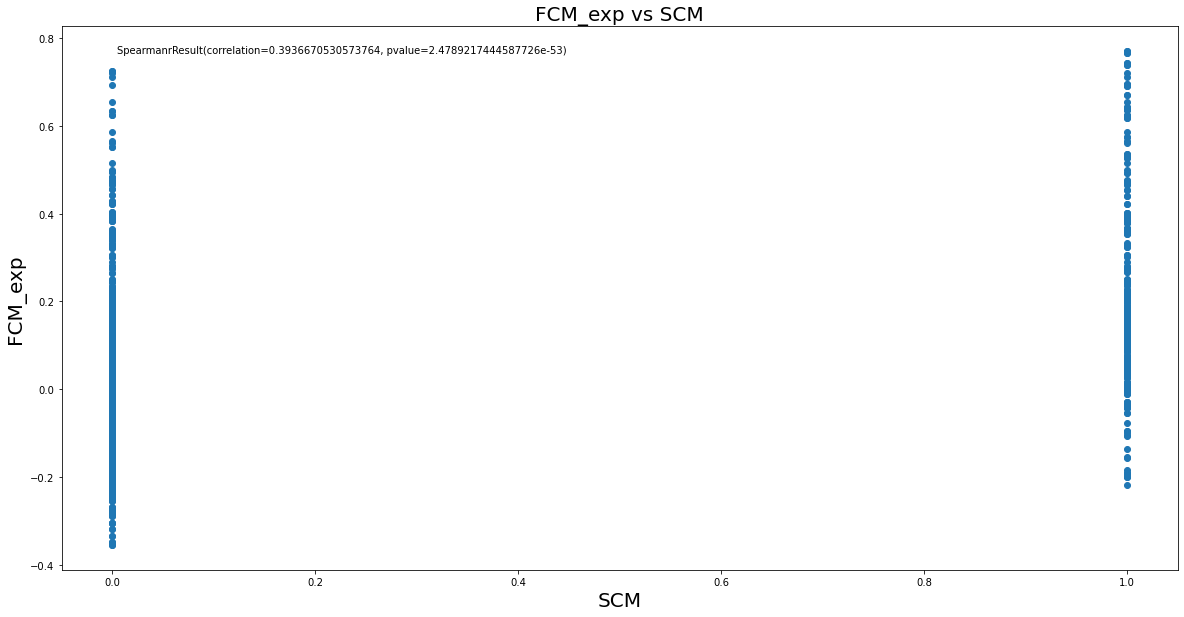

In [3]:
# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Set SCM as Binary
con.weights = con.weights!=0
SCM = con.weights

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Text(0.05, 0.95, 'SpearmanrResult(correlation=0.4050825623146923, pvalue=1.1867879692725426e-56)')

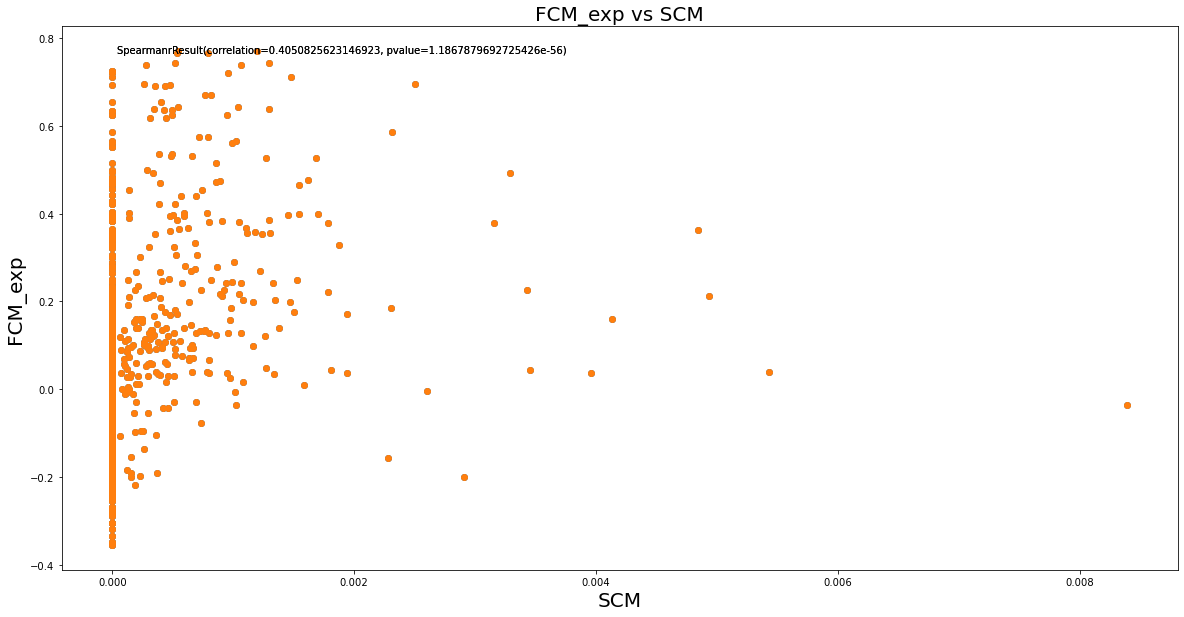

In [6]:
# Non-binary version

# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

SCM = con.weights

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

# Comparison of SCorr vs Selected Variable (G = Coupling constant)

 

In [3]:
# Get Scorr csv filenames in a folder
Scorr_files = glob.glob("do-not-track/*Scorr*.csv")

SCorr_array = []

# Loop to populate the empty array with the numbers from the Scorr csv files:

for item in Scorr_files:
    a = np.genfromtxt(item)
    SCorr_array.append(a[0])

print(Scorr_files)
print(SCorr_array)
print(numpy.amax(SCorr_array))
print(numpy.where(SCorr_array==np.amax(SCorr_array)))

# Check File order. 
# print(Scorr_files)

['do-not-track\\Het0.2_MouseCortex_Scorr_20200709-024708_.csv', 'do-not-track\\Het0.4_MouseCortex_Scorr_20200709-024705_.csv', 'do-not-track\\Het0.6000000000000001_MouseCortex_Scorr_20200709-024628_.csv', 'do-not-track\\Het0.8_MouseCortex_Scorr_20200709-024624_.csv', 'do-not-track\\Het1.0_MouseCortex_Scorr_20200709-024645_.csv']
[0.4397594864142922, 0.4100558451052147, 0.37660992410187405, 0.3423708811430093, 0.3106164270432738]
0.4397594864142922
(array([0], dtype=int64),)


Text(0.5, 1.0, 'Scorr vs G (of FC vs SC)')

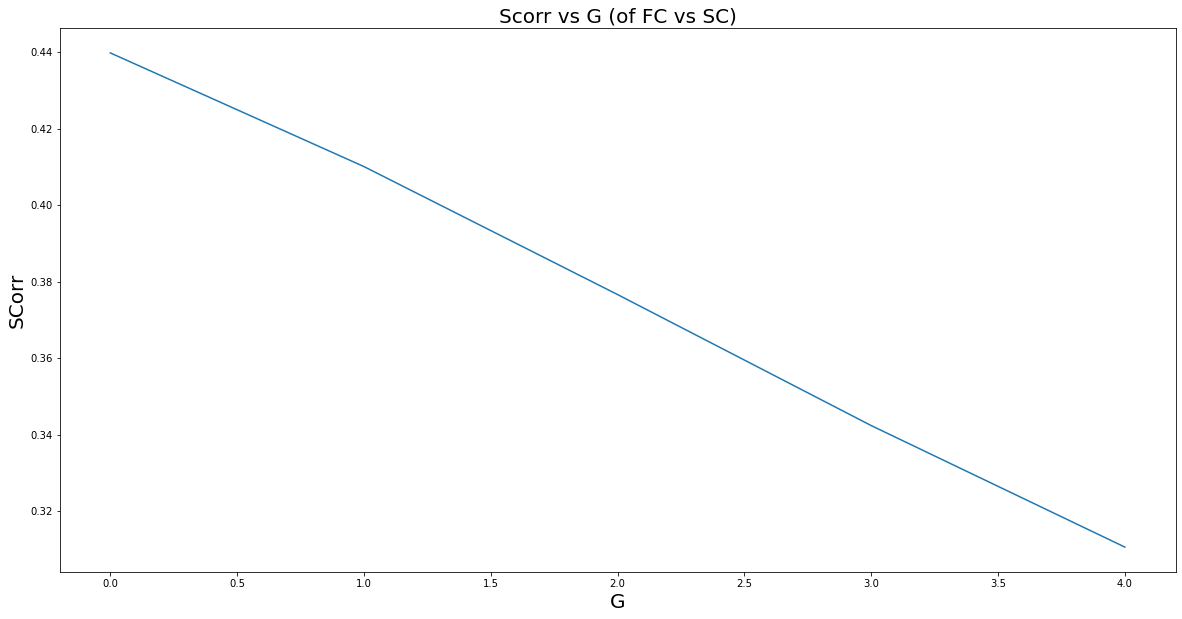

In [4]:
# Graph it: 
plt.plot(SCorr_array)
plt.xlabel('G', fontsize=20)
plt.ylabel('SCorr', fontsize=20)
plt.title('Scorr vs G (of FC vs SC)', fontsize=20)

In [8]:
# Scorr of FCM_exp vs FCM_sim vs G parameter

# Get FCM files
FCM_files = glob.glob("do-not-track/Het*FCM*.csv")

FCM_files

['do-not-track\\Het0.2_MouseCortex_FCM_20200709-024708_.csv',
 'do-not-track\\Het0.4_MouseCortex_FCM_20200709-024705_.csv',
 'do-not-track\\Het0.6000000000000001_MouseCortex_FCM_20200709-024628_.csv',
 'do-not-track\\Het0.8_MouseCortex_FCM_20200709-024624_.csv',
 'do-not-track\\Het1.0_MouseCortex_FCM_20200709-024645_.csv']

0.31848369348369343
(array([0], dtype=int64),)


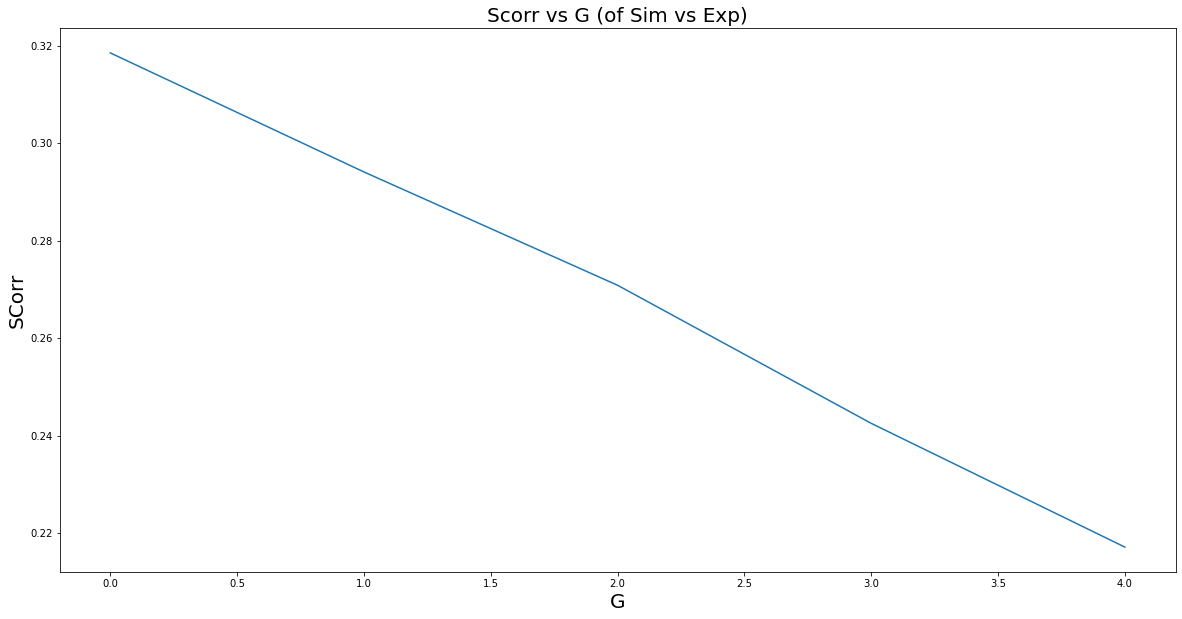

In [9]:
# Calcualte SCorr of FCM_sim vs FCM_exp

# FCM_exp
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")
# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

# Comparing FC_experimental Vs FC_Simulation with Spearman Correlation

SCorr_esim = []

FCM_Exp_U = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]  


for item in FCM_files:
    FCM_sim = np.genfromtxt(item)
    FCM_Sim_U = FCM_sim[np.triu_indices(FCM_sim.shape[0], k = 1)]      

    # Spearman Correlation
    SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
    SCorr_esim.append(SCorr[0])

# Graph it: 
plt.plot(SCorr_esim)
plt.xlabel('G', fontsize=20)
plt.ylabel('SCorr', fontsize=20)
plt.title('Scorr vs G (of Sim vs Exp)', fontsize=20)

print(numpy.amax(SCorr_esim))
print(numpy.where(SCorr_esim==np.amax(SCorr_esim)))

# Looking at a simulation run

In [31]:
# Ye dunno why having the closing square bracket messes up glob glob. 
Sim_run_files = glob.glob("do-not-track/Het0.2*_.csv")
Sim_run_files

['do-not-track\\Het0.2_MouseCortex_FCM_20200709-024708_.csv',
 'do-not-track\\Het0.2_MouseCortex_Params_20200709-024708_.csv',
 'do-not-track\\Het0.2_MouseCortex_Scorr_20200709-024708_.csv',
 'do-not-track\\Het0.2_MouseCortex_Tseries_20200709-024708_.csv']

In [32]:
# Read file import data
#df = pd.read_csv(all_files[11],delimiter="\t",header=None)
# Genfromtxt gives us a np array. 
df = np.genfromtxt(Sim_run_files[-1],delimiter="\t")

bold_time = df[0]
bold_data = df[1:]

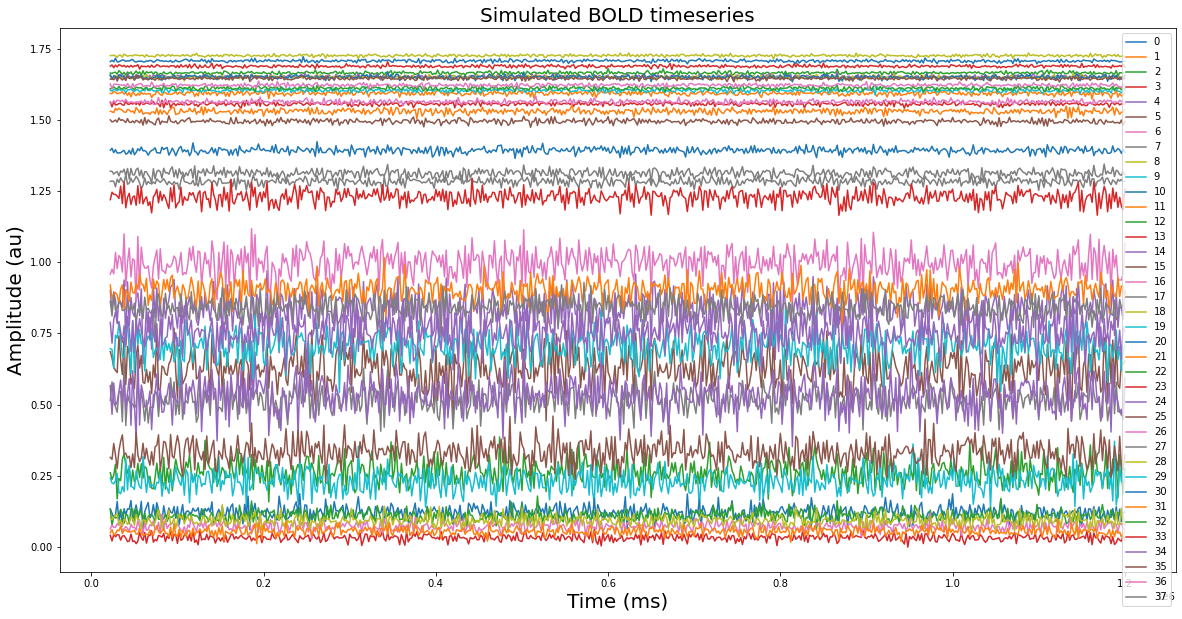

In [33]:
# plt.subplots()

#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')
for tseries in bold_data:
    plt.plot(bold_time,tseries)

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))

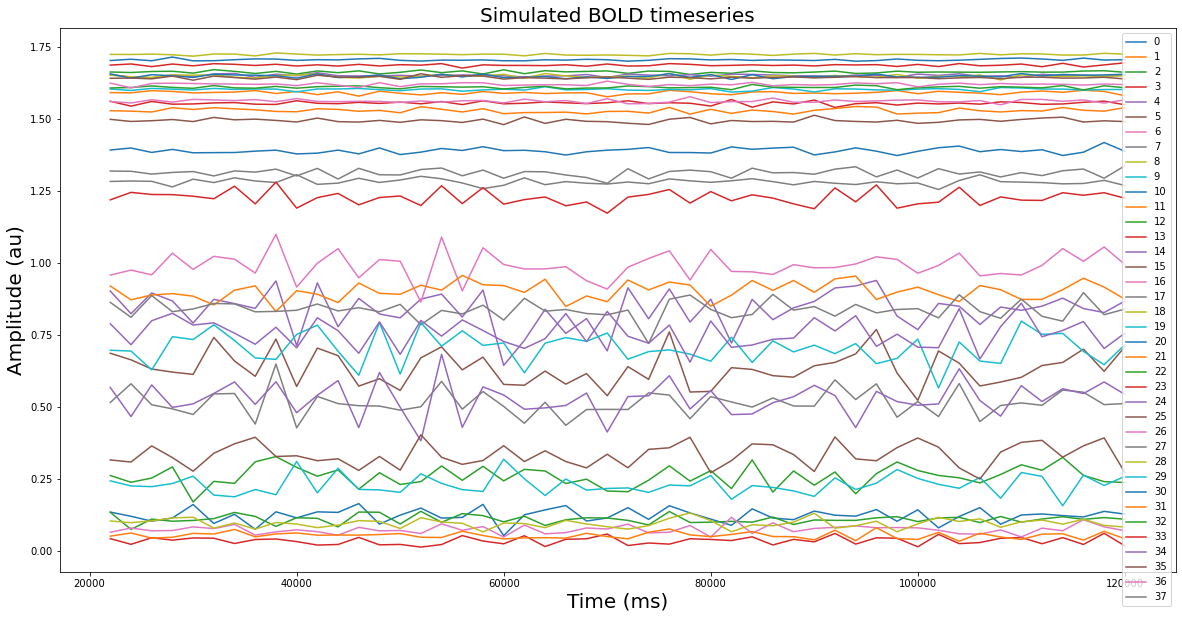

In [34]:
# plt.subplots()

#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')
for tseries in bold_data:
    plt.plot(bold_time[0:50],tseries[0:50])

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))

In [35]:
Scorra = np.genfromtxt(Sim_run_files[-2])
Scorra

array([4.39759486e-01, 1.45256666e-67])

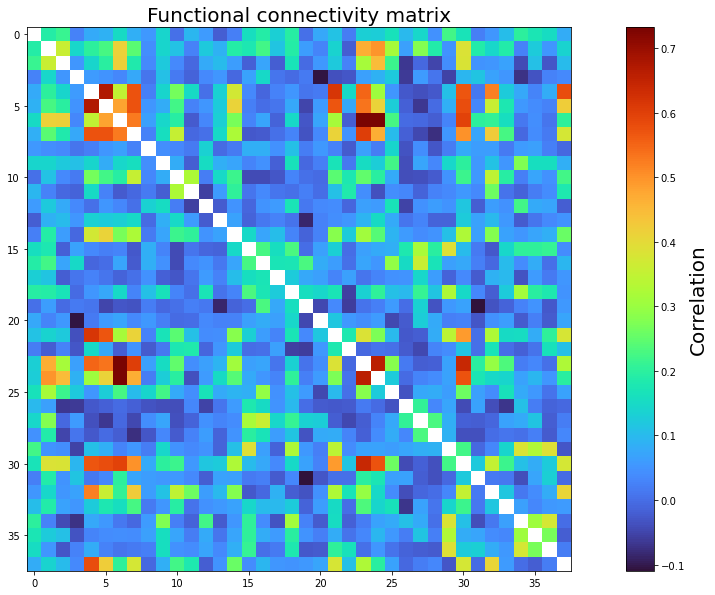

In [36]:
# Plot Simulated FCM
FCM_sim = np.genfromtxt(Sim_run_files[0],delimiter="\t")

# ListedColormap(turbo_colormap_data)
cs=plt.imshow(FCM_sim, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

Text(0.05, 0.95, 'SpearmanrResult(correlation=0.31848369348369343, pvalue=4.899580296158588e-18)')

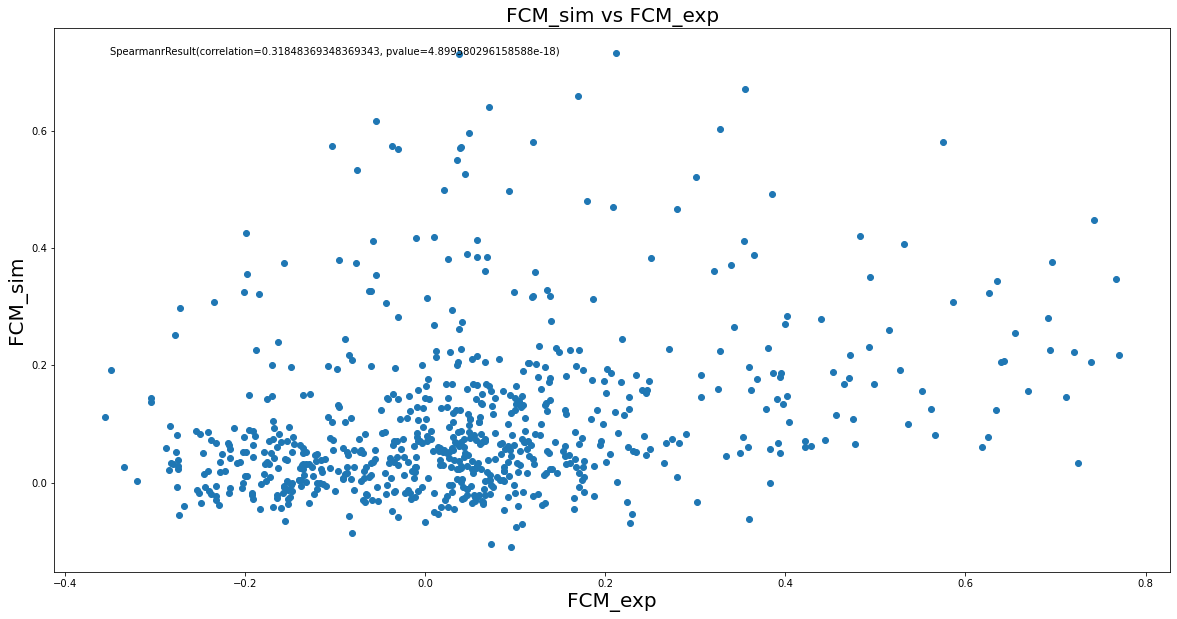

In [37]:
FCM_Exp_U = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
FCM_Sim_U = FCM_sim[np.triu_indices(FCM_sim.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Exp_U,FCM_Sim_U)
plt.xlabel('FCM_exp', fontsize=20)
plt.ylabel('FCM_sim', fontsize=20)
plt.title('FCM_sim vs FCM_exp', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')